In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import os
# Benzer bir şekilde böyle de yapılabilir (Beyzanınkinden farklı)
# Ana klasör yolunu belirtin
main_folder = "/Users/ranakaya/Downloads/archive/"

# Klasörlerin isimlerini belirtin
folders = ["Validation", "train","test"]

total_count=0

# Her bir klasör altındaki real ve fake klasörlerinin içindeki dosya sayısını alın
for folder_name in folders:
    folder_path = os.path.join(main_folder, folder_name)
    # real ve fake klasörlerinin isimlerini belirtin
    sub_folders = ["real", "fake"]
    for sub_folder_name in sub_folders:
        sub_folder_path = os.path.join(folder_path, sub_folder_name)
        # Klasördeki dosyaların listesini al
        files = os.listdir(sub_folder_path)
        # Dosya sayısını yazdır
        total_count+=len(files)
        #print(f"Klasör: {folder_name}/{sub_folder_name}, Dosya Sayısı: {len(files)}")
dataset_name="real-vs-fake"
print(f"{dataset_name} Veri seti Boyutu:", total_count)
''' 
test_dataset_path="real-vs-fake/test"
test_dataset_count=len(os.listdir(test_dataset_path))
print("Test veri seti boyutu:",test_dataset_count) '''


real-vs-fake Veri seti Boyutu: 2041


' \ntest_dataset_path="real-vs-fake/test"\ntest_dataset_count=len(os.listdir(test_dataset_path))\nprint("Test veri seti boyutu:",test_dataset_count) '

Deneme 1
* batch_size: 16
* optimizer: SGD
* learning_rate: 0.0001
* epoch sayısı: 20

In [3]:
batch_size = 16  # bir eğitim döngüsüne kaç tane veri verileceğini belirler (aynı anda)
image_size = 224

import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_transform = transforms.Compose([
    transforms.ToTensor(),
    # Gerekirse diğer dönüşümleri ekleyin, örneğin normalize etme
    # transforms.Normalize(mean=[0.5], std=[0.5])
])


train_data = ImageFolder(root=os.path.join(main_folder, "train"), transform=transform)
validation_data = ImageFolder(root=os.path.join(main_folder, "Validation"), transform=transform)
test_data = ImageFolder(root=os.path.join(main_folder, "test"), transform=train_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle = False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle = False)

In [4]:
# Model oluşturma
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.base_model = torchvision.models.mobilenet_v3_small(pretrained=True)
        num_features = self.base_model.classifier[-1].in_features
        self.base_model.classifier[-1] = nn.Linear(num_features, 1)


    def forward(self, x):
        return torch.sigmoid(self.base_model(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomModel().to(device)

# Kayıp fonksiyonu ve optimizer
criterion = nn.BCELoss()

optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Modelin özellik çıkarıcısının çıkış boyutunu kontrol etme
dummy_input = torch.randn(1, 3, 224, 224).to(device)
features = model.base_model.features(dummy_input)
print(f'Feature shape: {features.shape}')


/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature shape: torch.Size([1, 576, 7, 7])


In [5]:
num_epochs = 20
best_accuracy = 0.0
early_stopping_counter = 0

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in range(num_epochs):
    # Eğitim aşaması
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Doğrulama aşaması
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            running_val_loss += loss.item() * images.size(0)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss = running_val_loss / len(validation_loader.dataset)
    val_accuracy = correct / total
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    # Early stopping kontrolü
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 5:
            print("Early stopping triggered.")
            break


Epoch 1/20, Train Loss: 0.6985, Train Accuracy: 0.5121, Validation Loss: 0.6968, Validation Accuracy: 0.5156
Epoch 2/20, Train Loss: 0.6897, Train Accuracy: 0.5405, Validation Loss: 0.6907, Validation Accuracy: 0.5254
Epoch 3/20, Train Loss: 0.6820, Train Accuracy: 0.5589, Validation Loss: 0.6849, Validation Accuracy: 0.5625
Epoch 4/20, Train Loss: 0.6720, Train Accuracy: 0.5890, Validation Loss: 0.6802, Validation Accuracy: 0.5605
Epoch 5/20, Train Loss: 0.6616, Train Accuracy: 0.6065, Validation Loss: 0.6766, Validation Accuracy: 0.5723
Epoch 6/20, Train Loss: 0.6574, Train Accuracy: 0.6207, Validation Loss: 0.6741, Validation Accuracy: 0.5859
Epoch 7/20, Train Loss: 0.6505, Train Accuracy: 0.6391, Validation Loss: 0.6709, Validation Accuracy: 0.5957
Epoch 8/20, Train Loss: 0.6426, Train Accuracy: 0.6391, Validation Loss: 0.6686, Validation Accuracy: 0.6016
Epoch 9/20, Train Loss: 0.6389, Train Accuracy: 0.6541, Validation Loss: 0.6671, Validation Accuracy: 0.6016
Epoch 10/20, Train 

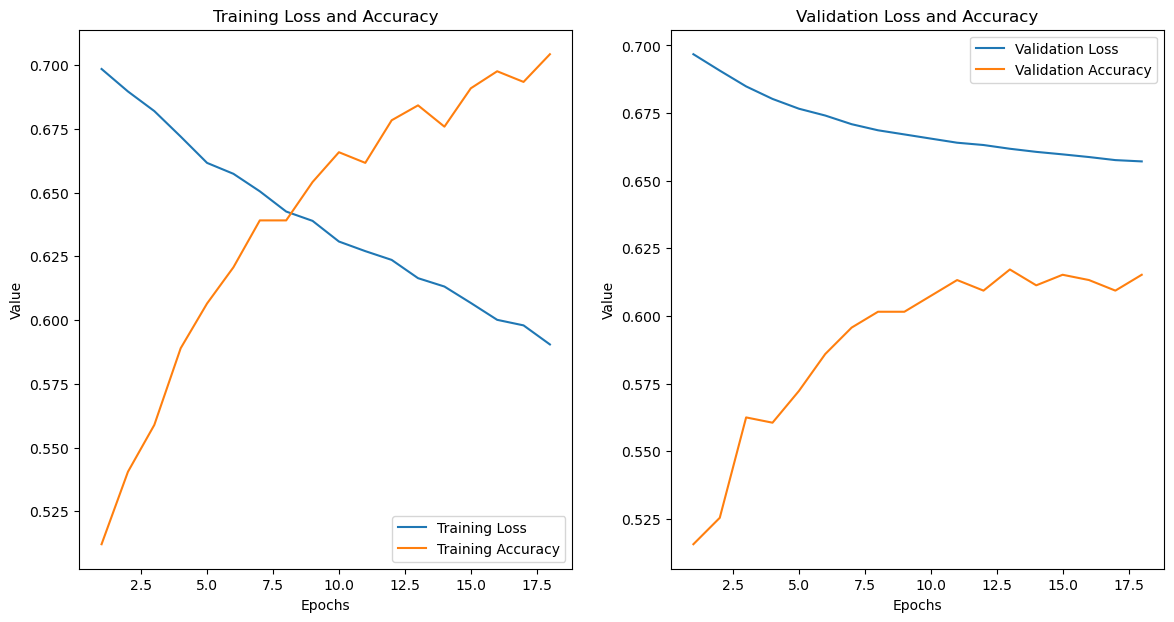

In [6]:
# Listelerin uzunluklarını kontrol etme ve en kısa listenin uzunluğunu bulma
min_length = min(len(train_losses), len(validation_losses), len(train_accuracies), len(validation_losses), num_epochs)

# Tüm listeleri en kısa uzunluğa göre kesme
train_losses = train_losses[:min_length]
val_losses = validation_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_accuracies = validation_accuracies[:min_length]

# Grafik çizme
plt.figure(figsize=(14, 7))

# Eğitim Kayıpları ve Doğrulukları Grafiği
plt.subplot(1, 2, 1)
plt.plot(range(1, min_length + 1), train_losses, label='Training Loss')
plt.plot(range(1, min_length + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()

# Doğrulama Kayıpları ve Doğrulukları Grafiği
plt.subplot(1, 2, 2)
plt.plot(range(1, min_length + 1), val_losses, label='Validation Loss')
plt.plot(range(1, min_length + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation Loss and Accuracy')
plt.legend()

plt.show()


In [18]:
# Test
model.eval()
running_test_loss = 0.0

predictions = []
true_labels = []

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        running_test_loss += loss.item() * images.size(0)
        predicted = torch.round(outputs)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

test_loss = running_test_loss / len(test_loader.dataset)
test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.6695, Test Accuracy: 0.6024


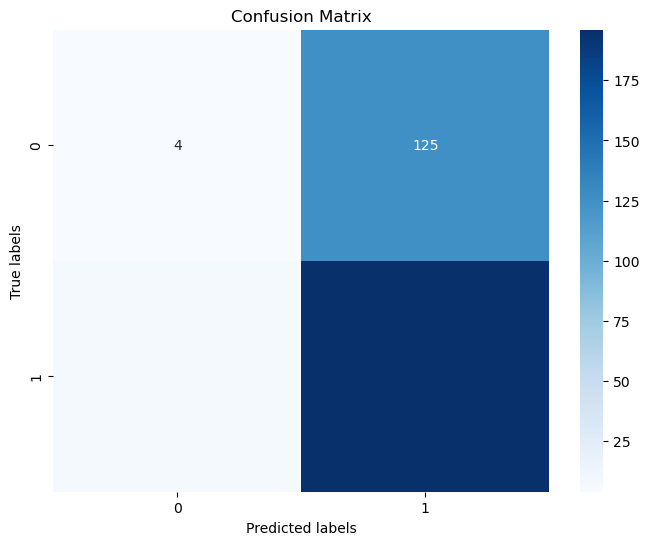

<function confusion_matrix at 0x14f636170>


In [13]:
# Confusion matrix ve görselleştirme
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(confusion_matrix)

In [14]:
print(conf_matrix)

[[  4 125]
 [  7 196]]


Deneme 2
* batch_size: 16
* optimizer: Adam
* learning_rate: 0.0001
* epoch sayısı: 20

In [4]:
# Model oluşturma
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.base_model = torchvision.models.mobilenet_v3_small(pretrained=True)
        num_features = self.base_model.classifier[-1].in_features
        self.base_model.classifier[-1] = nn.Linear(num_features, 1)


    def forward(self, x):
        return torch.sigmoid(self.base_model(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomModel().to(device)

# Kayıp fonksiyonu ve optimizer
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Modelin özellik çıkarıcısının çıkış boyutunu kontrol etme
dummy_input = torch.randn(1, 3, 224, 224).to(device)
features = model.base_model.features(dummy_input)
print(f'Feature shape: {features.shape}')


/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature shape: torch.Size([1, 576, 7, 7])


In [5]:
num_epochs = 20
best_accuracy = 0.0
early_stopping_counter = 0

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in range(num_epochs):
    # Eğitim aşaması
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Doğrulama aşaması
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            running_val_loss += loss.item() * images.size(0)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss = running_val_loss / len(validation_loader.dataset)
    val_accuracy = correct / total
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    # Early stopping kontrolü
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 5:
            print("Early stopping triggered.")
            break


Epoch 1/20, Train Loss: 0.6595, Train Accuracy: 0.5906, Validation Loss: 0.6978, Validation Accuracy: 0.5352
Epoch 2/20, Train Loss: 0.5551, Train Accuracy: 0.7335, Validation Loss: 0.6295, Validation Accuracy: 0.6680
Epoch 3/20, Train Loss: 0.4335, Train Accuracy: 0.8003, Validation Loss: 0.6579, Validation Accuracy: 0.7012
Epoch 4/20, Train Loss: 0.3315, Train Accuracy: 0.8630, Validation Loss: 0.6786, Validation Accuracy: 0.6758
Epoch 5/20, Train Loss: 0.2192, Train Accuracy: 0.9256, Validation Loss: 0.7469, Validation Accuracy: 0.6953
Epoch 6/20, Train Loss: 0.1371, Train Accuracy: 0.9541, Validation Loss: 0.8950, Validation Accuracy: 0.7051
Epoch 7/20, Train Loss: 0.0952, Train Accuracy: 0.9708, Validation Loss: 0.9860, Validation Accuracy: 0.6914
Epoch 8/20, Train Loss: 0.0835, Train Accuracy: 0.9733, Validation Loss: 1.0734, Validation Accuracy: 0.6914
Epoch 9/20, Train Loss: 0.0520, Train Accuracy: 0.9850, Validation Loss: 1.1706, Validation Accuracy: 0.6875
Epoch 10/20, Train 

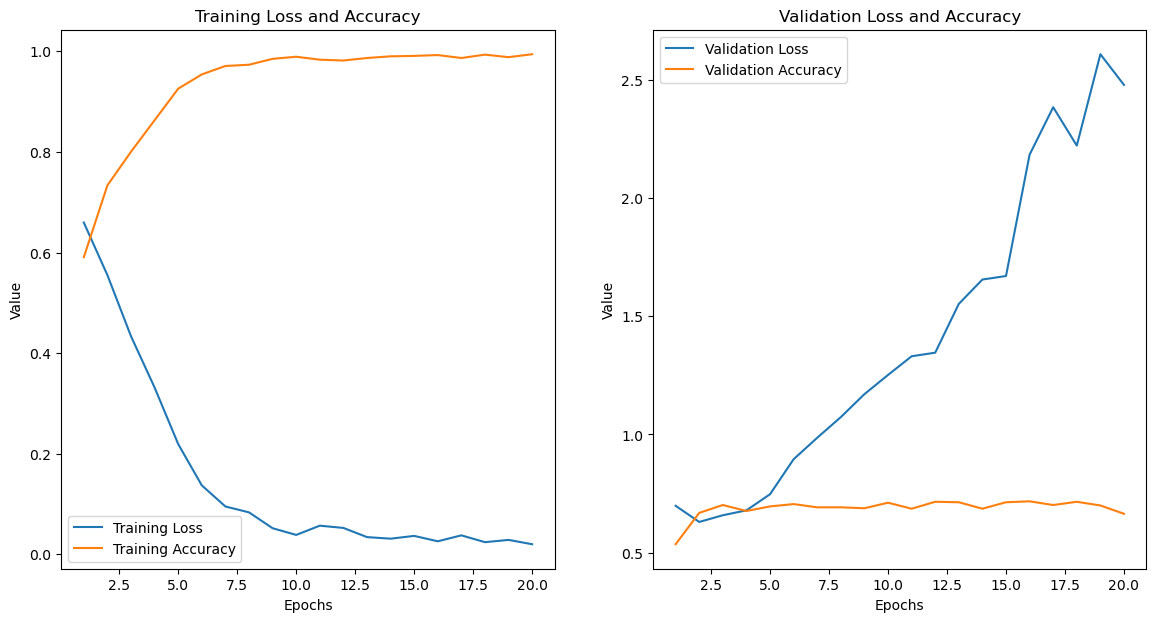

In [6]:
# Listelerin uzunluklarını kontrol etme ve en kısa listenin uzunluğunu bulma
min_length = min(len(train_losses), len(validation_losses), len(train_accuracies), len(validation_losses), num_epochs)

# Tüm listeleri en kısa uzunluğa göre kesme
train_losses = train_losses[:min_length]
val_losses = validation_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_accuracies = validation_accuracies[:min_length]

# Grafik çizme
plt.figure(figsize=(14, 7))

# Eğitim Kayıpları ve Doğrulukları Grafiği
plt.subplot(1, 2, 1)
plt.plot(range(1, min_length + 1), train_losses, label='Training Loss')
plt.plot(range(1, min_length + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()

# Doğrulama Kayıpları ve Doğrulukları Grafiği
plt.subplot(1, 2, 2)
plt.plot(range(1, min_length + 1), val_losses, label='Validation Loss')
plt.plot(range(1, min_length + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation Loss and Accuracy')
plt.legend()

plt.show()


In [7]:
# Test
model.eval()
running_test_loss = 0.0

predictions = []
true_labels = []

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        running_test_loss += loss.item() * images.size(0)
        predicted = torch.round(outputs)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

test_loss = running_test_loss / len(test_loader.dataset)
test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 3.6492, Test Accuracy: 0.5843


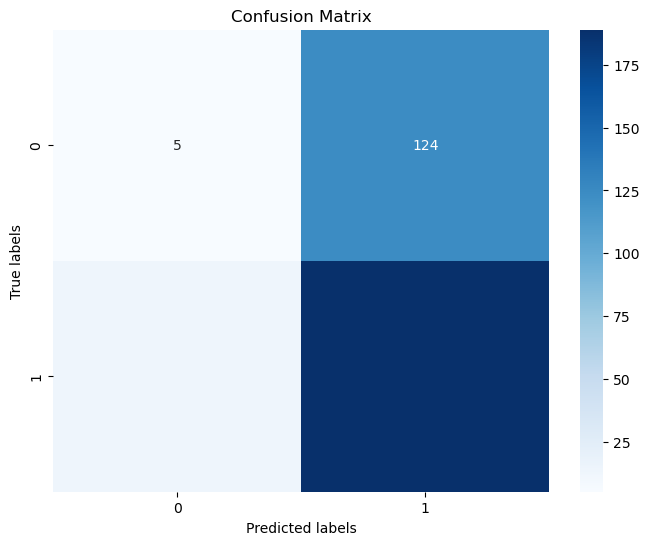

[[  5 124]
 [ 14 189]]


In [8]:
# Confusion matrix ve görselleştirme
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(conf_matrix)

Deneme 3
* batch_size: 16
* optimizer: SGD
* learning_rate: 0.001
* epoch sayısı: 20

In [9]:
batch_size = 16  # bir eğitim döngüsüne kaç tane veri verileceğini belirler (aynı anda)
image_size = 224

import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_transform = transforms.Compose([
    transforms.ToTensor(),
    # Gerekirse diğer dönüşümleri ekleyin, örneğin normalize etme
    # transforms.Normalize(mean=[0.5], std=[0.5])
])


train_data = ImageFolder(root=os.path.join(main_folder, "train"), transform=transform)
validation_data = ImageFolder(root=os.path.join(main_folder, "Validation"), transform=transform)
test_data = ImageFolder(root=os.path.join(main_folder, "test"), transform=train_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle = False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle = False)

In [10]:
# Model oluşturma
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.base_model = torchvision.models.mobilenet_v3_small(pretrained=True)
        num_features = self.base_model.classifier[-1].in_features
        self.base_model.classifier[-1] = nn.Linear(num_features, 1)


    def forward(self, x):
        return torch.sigmoid(self.base_model(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomModel().to(device)

# Kayıp fonksiyonu ve optimizer
criterion = nn.BCELoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Modelin özellik çıkarıcısının çıkış boyutunu kontrol etme
dummy_input = torch.randn(1, 3, 224, 224).to(device)
features = model.base_model.features(dummy_input)
print(f'Feature shape: {features.shape}')


/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature shape: torch.Size([1, 576, 7, 7])


In [11]:
num_epochs = 20
best_accuracy = 0.0
early_stopping_counter = 0

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in range(num_epochs):
    # Eğitim aşaması
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Doğrulama aşaması
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            running_val_loss += loss.item() * images.size(0)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss = running_val_loss / len(validation_loader.dataset)
    val_accuracy = correct / total
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    # Early stopping kontrolü
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 5:
            print("Early stopping triggered.")
            break


Epoch 1/20, Train Loss: 0.6810, Train Accuracy: 0.5530, Validation Loss: 0.6863, Validation Accuracy: 0.5527
Epoch 2/20, Train Loss: 0.6197, Train Accuracy: 0.6625, Validation Loss: 0.6668, Validation Accuracy: 0.6016
Epoch 3/20, Train Loss: 0.5841, Train Accuracy: 0.7001, Validation Loss: 0.6631, Validation Accuracy: 0.6211
Epoch 4/20, Train Loss: 0.5439, Train Accuracy: 0.7368, Validation Loss: 0.6534, Validation Accuracy: 0.6445
Epoch 5/20, Train Loss: 0.5070, Train Accuracy: 0.7611, Validation Loss: 0.6513, Validation Accuracy: 0.6348
Epoch 6/20, Train Loss: 0.4667, Train Accuracy: 0.8003, Validation Loss: 0.6449, Validation Accuracy: 0.6621
Epoch 7/20, Train Loss: 0.4214, Train Accuracy: 0.8170, Validation Loss: 0.6469, Validation Accuracy: 0.6680
Epoch 8/20, Train Loss: 0.3858, Train Accuracy: 0.8271, Validation Loss: 0.6505, Validation Accuracy: 0.6680
Epoch 9/20, Train Loss: 0.3549, Train Accuracy: 0.8429, Validation Loss: 0.6503, Validation Accuracy: 0.6973
Epoch 10/20, Train 

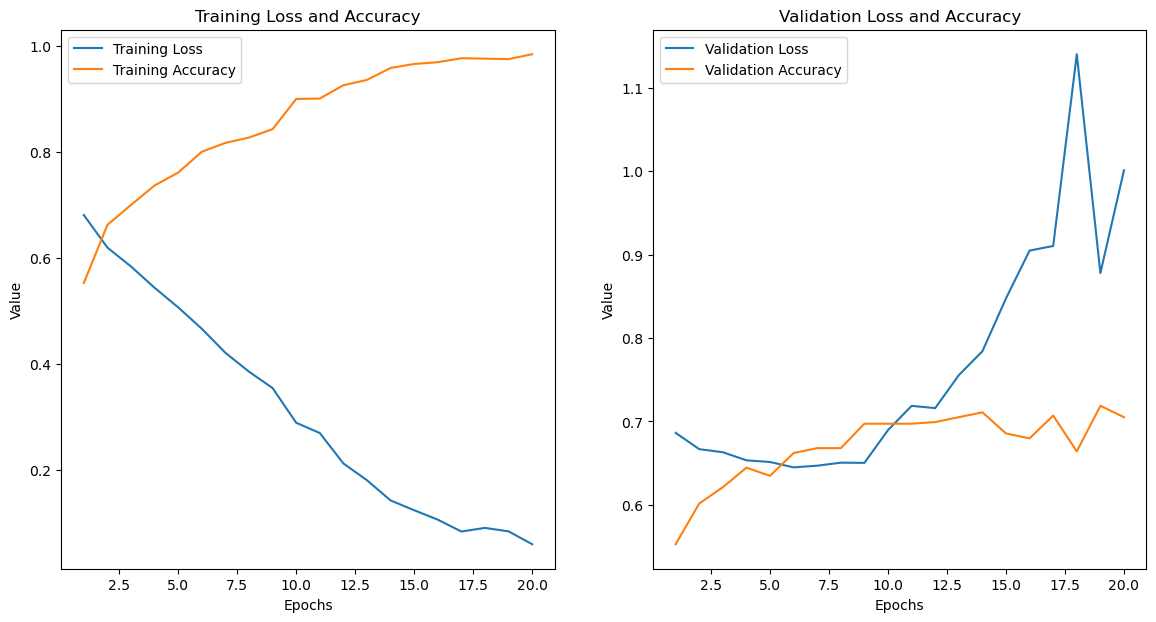

In [12]:
# Listelerin uzunluklarını kontrol etme ve en kısa listenin uzunluğunu bulma
min_length = min(len(train_losses), len(validation_losses), len(train_accuracies), len(validation_losses), num_epochs)

# Tüm listeleri en kısa uzunluğa göre kesme
train_losses = train_losses[:min_length]
val_losses = validation_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_accuracies = validation_accuracies[:min_length]

# Grafik çizme
plt.figure(figsize=(14, 7))

# Eğitim Kayıpları ve Doğrulukları Grafiği
plt.subplot(1, 2, 1)
plt.plot(range(1, min_length + 1), train_losses, label='Training Loss')
plt.plot(range(1, min_length + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()

# Doğrulama Kayıpları ve Doğrulukları Grafiği
plt.subplot(1, 2, 2)
plt.plot(range(1, min_length + 1), val_losses, label='Validation Loss')
plt.plot(range(1, min_length + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation Loss and Accuracy')
plt.legend()

plt.show()


In [13]:
# Test
model.eval()
running_test_loss = 0.0

predictions = []
true_labels = []

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        running_test_loss += loss.item() * images.size(0)
        predicted = torch.round(outputs)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

test_loss = running_test_loss / len(test_loader.dataset)
test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 1.3719, Test Accuracy: 0.6084


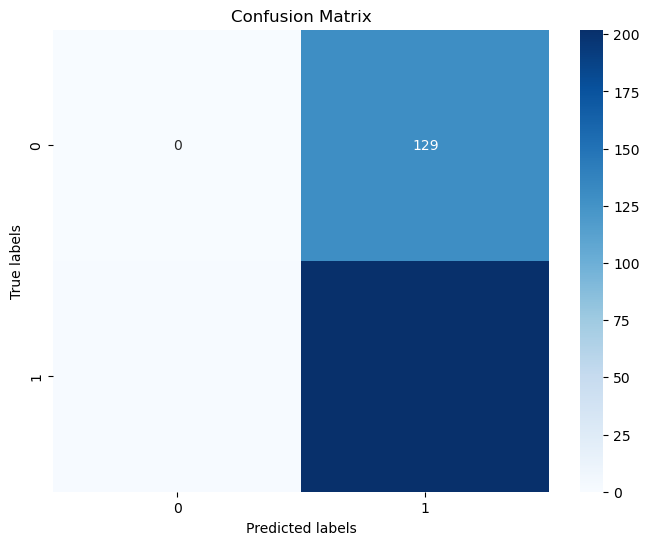

[[  0 129]
 [  1 202]]


In [14]:
# Confusion matrix ve görselleştirme
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(conf_matrix)

Deneme 4
* batch_size: 16
* optimizer: SGD
* learning_rate: 0.001
* epoch sayısı: 20
* dropout eklendi

In [4]:
batch_size = 16  # bir eğitim döngüsüne kaç tane veri verileceğini belirler (aynı anda)
image_size = 224

import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_data = ImageFolder(root=os.path.join(main_folder, "train"), transform=transform)
validation_data = ImageFolder(root=os.path.join(main_folder, "Validation"), transform=transform)
test_data = ImageFolder(root=os.path.join(main_folder, "test"), transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle = False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle = False)

In [5]:
# Model oluşturma
class CustomModel(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(CustomModel, self).__init__()
        self.base_model = torchvision.models.mobilenet_v3_small(pretrained=True)
        num_features = self.base_model.classifier[-1].in_features
        self.base_model.classifier[-1] = nn.Linear(num_features, 1)
        self.dropout = nn.Dropout(dropout_prob)


    def forward(self, x):
        x = self.base_model(x)
        x = self.dropout(x)
        return torch.sigmoid(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomModel().to(device)

# Kayıp fonksiyonu ve optimizer
criterion = nn.BCELoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Modelin özellik çıkarıcısının çıkış boyutunu kontrol etme
dummy_input = torch.randn(1, 3, 224, 224).to(device)
features = model.base_model.features(dummy_input)
print(f'Feature shape: {features.shape}')


/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature shape: torch.Size([1, 576, 7, 7])


In [6]:
num_epochs = 20
best_accuracy = 0.0
early_stopping_counter = 0

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in range(num_epochs):
    # Eğitim aşaması
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Doğrulama aşaması
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            running_val_loss += loss.item() * images.size(0)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss = running_val_loss / len(validation_loader.dataset)
    val_accuracy = correct / total
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    # Early stopping kontrolü
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 5:
            print("Early stopping triggered.")
            break


Epoch 1/20, Train Loss: 0.6919, Train Accuracy: 0.5004, Validation Loss: 0.6897, Validation Accuracy: 0.5195
Epoch 2/20, Train Loss: 0.6517, Train Accuracy: 0.5581, Validation Loss: 0.6611, Validation Accuracy: 0.6016
Epoch 3/20, Train Loss: 0.6308, Train Accuracy: 0.5664, Validation Loss: 0.6564, Validation Accuracy: 0.6230
Epoch 4/20, Train Loss: 0.6272, Train Accuracy: 0.5823, Validation Loss: 0.6404, Validation Accuracy: 0.6270
Epoch 5/20, Train Loss: 0.6031, Train Accuracy: 0.5990, Validation Loss: 0.6380, Validation Accuracy: 0.6504
Epoch 6/20, Train Loss: 0.5849, Train Accuracy: 0.5982, Validation Loss: 0.6403, Validation Accuracy: 0.6328
Epoch 7/20, Train Loss: 0.5685, Train Accuracy: 0.6157, Validation Loss: 0.6331, Validation Accuracy: 0.6582
Epoch 8/20, Train Loss: 0.5511, Train Accuracy: 0.6483, Validation Loss: 0.6295, Validation Accuracy: 0.6738
Epoch 9/20, Train Loss: 0.5435, Train Accuracy: 0.6316, Validation Loss: 0.6231, Validation Accuracy: 0.6582
Epoch 10/20, Train 

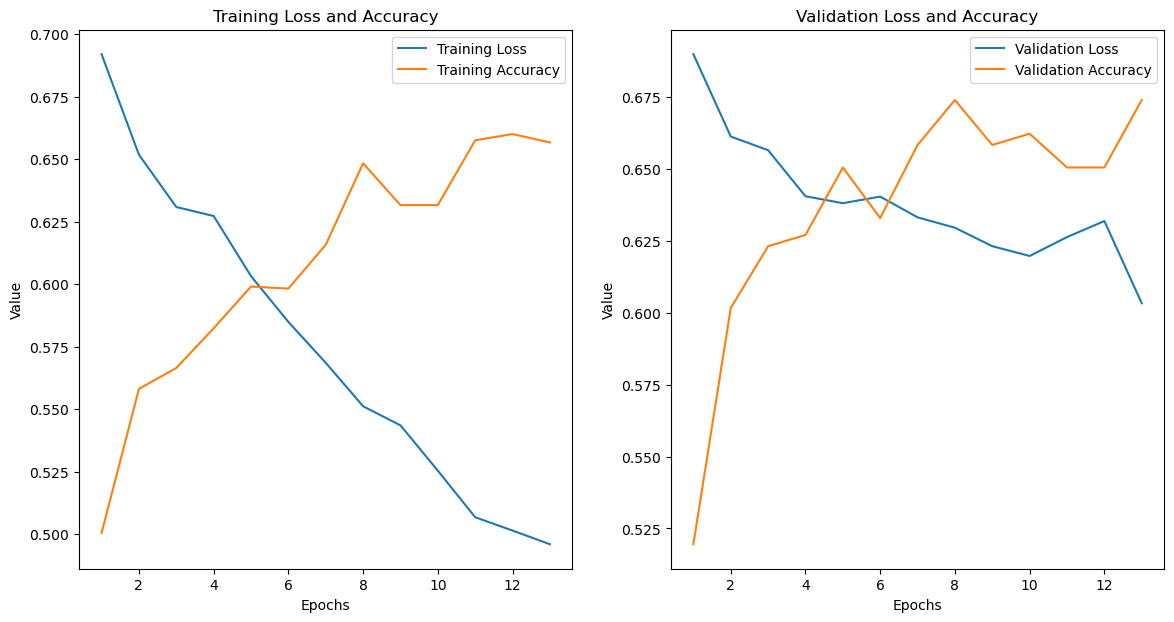

In [7]:
# Listelerin uzunluklarını kontrol etme ve en kısa listenin uzunluğunu bulma
min_length = min(len(train_losses), len(validation_losses), len(train_accuracies), len(validation_losses), num_epochs)

# Tüm listeleri en kısa uzunluğa göre kesme
train_losses = train_losses[:min_length]
val_losses = validation_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_accuracies = validation_accuracies[:min_length]

# Grafik çizme
plt.figure(figsize=(14, 7))

# Eğitim Kayıpları ve Doğrulukları Grafiği
plt.subplot(1, 2, 1)
plt.plot(range(1, min_length + 1), train_losses, label='Training Loss')
plt.plot(range(1, min_length + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()

# Doğrulama Kayıpları ve Doğrulukları Grafiği
plt.subplot(1, 2, 2)
plt.plot(range(1, min_length + 1), val_losses, label='Validation Loss')
plt.plot(range(1, min_length + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation Loss and Accuracy')
plt.legend()

plt.show()


In [8]:
# Test
model.eval()
running_test_loss = 0.0

predictions = []
true_labels = []

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        running_test_loss += loss.item() * images.size(0)
        predicted = torch.round(outputs)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

test_loss = running_test_loss / len(test_loader.dataset)
test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.7041, Test Accuracy: 0.5813


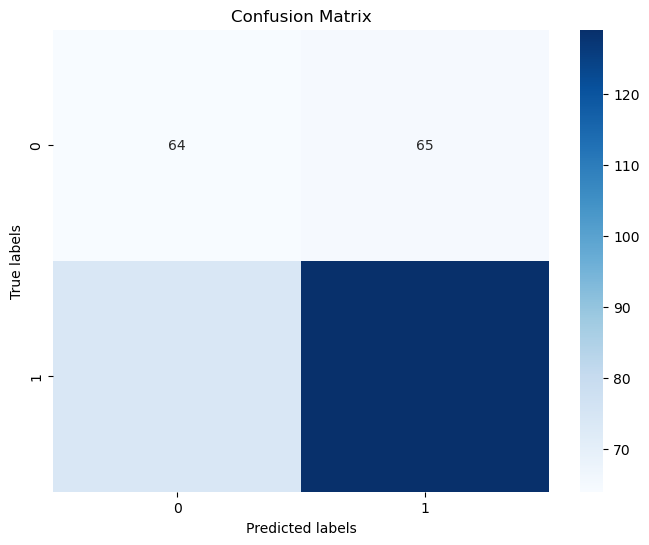

[[ 64  65]
 [ 74 129]]


In [9]:
# Confusion matrix ve görselleştirme
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(conf_matrix)

Deneme 5
* batch_size: 16
* optimizer: SGD
* learning_rate: 0.001
* epoch sayısı: 20
* dropout eklendi
* transform' a ekleme yapıldı.

In [12]:
batch_size = 16  # bir eğitim döngüsüne kaç tane veri verileceğini belirler (aynı anda)
image_size = 224

import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform2 = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_data = ImageFolder(root=os.path.join(main_folder, "train"), transform=transform2)
validation_data = ImageFolder(root=os.path.join(main_folder, "Validation"), transform=transform2)
test_data = ImageFolder(root=os.path.join(main_folder, "test"), transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle = False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle = False)

In [13]:
# Model oluşturma
class CustomModel(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(CustomModel, self).__init__()
        self.base_model = torchvision.models.mobilenet_v3_small(pretrained=True)
        num_features = self.base_model.classifier[-1].in_features
        self.base_model.classifier[-1] = nn.Linear(num_features, 1)
        self.dropout = nn.Dropout(dropout_prob)


    def forward(self, x):
        x = self.base_model(x)
        x = self.dropout(x)
        return torch.sigmoid(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomModel().to(device)

# Kayıp fonksiyonu ve optimizer
criterion = nn.BCELoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Modelin özellik çıkarıcısının çıkış boyutunu kontrol etme
dummy_input = torch.randn(1, 3, 224, 224).to(device)
features = model.base_model.features(dummy_input)
print(f'Feature shape: {features.shape}')


Feature shape: torch.Size([1, 576, 7, 7])


/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
num_epochs = 20
best_accuracy = 0.0
early_stopping_counter = 0

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in range(num_epochs):
    # Eğitim aşaması
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Doğrulama aşaması
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            running_val_loss += loss.item() * images.size(0)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss = running_val_loss / len(validation_loader.dataset)
    val_accuracy = correct / total
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    # Early stopping kontrolü
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 5:
            print("Early stopping triggered.")
            break


Epoch 1/20, Train Loss: 0.7020, Train Accuracy: 0.4779, Validation Loss: 0.6964, Validation Accuracy: 0.5391
Epoch 2/20, Train Loss: 0.6699, Train Accuracy: 0.5322, Validation Loss: 0.6750, Validation Accuracy: 0.5840
Epoch 3/20, Train Loss: 0.6754, Train Accuracy: 0.5455, Validation Loss: 0.6598, Validation Accuracy: 0.6230
Epoch 4/20, Train Loss: 0.6551, Train Accuracy: 0.5464, Validation Loss: 0.6578, Validation Accuracy: 0.6172
Epoch 5/20, Train Loss: 0.6665, Train Accuracy: 0.5564, Validation Loss: 0.6467, Validation Accuracy: 0.6211
Epoch 6/20, Train Loss: 0.6472, Train Accuracy: 0.5572, Validation Loss: 0.6458, Validation Accuracy: 0.6328
Epoch 7/20, Train Loss: 0.6544, Train Accuracy: 0.5497, Validation Loss: 0.6458, Validation Accuracy: 0.6055
Epoch 8/20, Train Loss: 0.6428, Train Accuracy: 0.5614, Validation Loss: 0.6473, Validation Accuracy: 0.6270
Epoch 9/20, Train Loss: 0.6378, Train Accuracy: 0.5748, Validation Loss: 0.6437, Validation Accuracy: 0.6387
Epoch 10/20, Train 

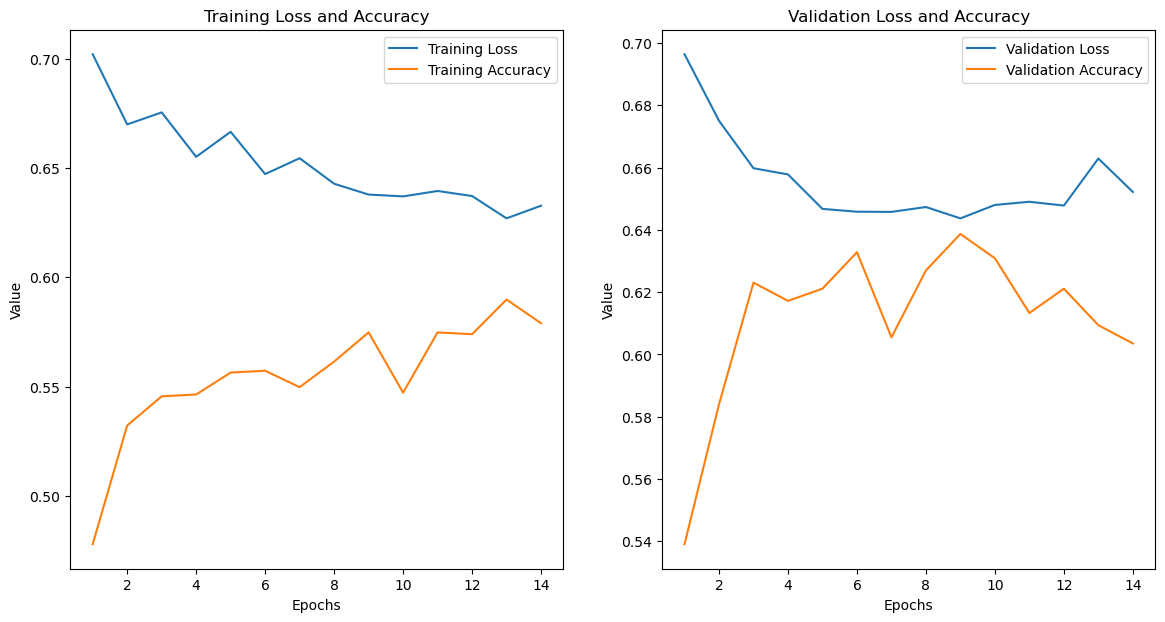

In [15]:
# Listelerin uzunluklarını kontrol etme ve en kısa listenin uzunluğunu bulma
min_length = min(len(train_losses), len(validation_losses), len(train_accuracies), len(validation_losses), num_epochs)

# Tüm listeleri en kısa uzunluğa göre kesme
train_losses = train_losses[:min_length]
val_losses = validation_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_accuracies = validation_accuracies[:min_length]

# Grafik çizme
plt.figure(figsize=(14, 7))

# Eğitim Kayıpları ve Doğrulukları Grafiği
plt.subplot(1, 2, 1)
plt.plot(range(1, min_length + 1), train_losses, label='Training Loss')
plt.plot(range(1, min_length + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()

# Doğrulama Kayıpları ve Doğrulukları Grafiği
plt.subplot(1, 2, 2)
plt.plot(range(1, min_length + 1), val_losses, label='Validation Loss')
plt.plot(range(1, min_length + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation Loss and Accuracy')
plt.legend()

plt.show()


In [18]:
# Test
model.eval()
running_test_loss = 0.0

predictions = []
true_labels = []

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        running_test_loss += loss.item() * images.size(0)
        predicted = torch.round(outputs)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

test_loss = running_test_loss / len(test_loader.dataset)
test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.6995, Test Accuracy: 0.5392


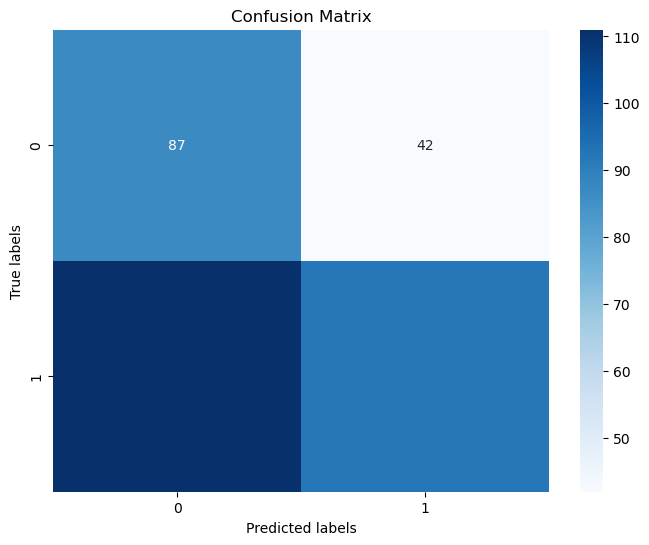

[[ 87  42]
 [111  92]]


In [19]:
# Confusion matrix ve görselleştirme
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(conf_matrix)